In [2]:
from __future__ import absolute_import
from __future__ import print_function
import numpy as np
import numpy
import PIL
from PIL import Image
np.random.seed(1337)  # for reproducibility

import random
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Input, Lambda
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import Flatten
from keras.optimizers import RMSprop
from keras import backend as K


def euclidean_distance(vects):
    x, y = vects
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

#def softmax(z): return np.exp(z)/((np.exp(z)).sum())

def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 1
    return K.mean(y_true * K.square(y_pred) + (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))

def kullback_leibler_divergence(y_true, y_pred):
    y_true = K.clip(y_true, K.epsilon(), 1)
    y_pred = K.clip(y_pred, K.epsilon(), 1)
    return K.sum(y_true * K.log(y_true / y_pred), axis=-1)


def create_pairs(x, digit_indices):
    '''Positive and negative pair creation.
    Alternates between positive and negative pairs.
    '''
    pairs = []
    labels = []
    n = min([len(digit_indices[d]) for d in range(10)]) - 1
    for d in range(10):
        for i in range(n):
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
            pairs += [[x[z1], x[z2]]]
            inc = random.randrange(1, 10)
            dn = (d + inc) % 10
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            pairs += [[x[z1], x[z2]]]
            labels += [1, 0]
    return np.array(pairs), np.array(labels)


def create_base_network():
    '''Base network to be shared (eq. to feature extraction).
    '''
    seq = Sequential()
    seq.add(Conv2D(30, (5, 5), input_shape=(28, 28,1), activation='relu'))
    seq.add(MaxPooling2D(pool_size=(2, 2)))
    seq.add(Dropout(0.2))
    seq.add(Flatten())
    seq.add(Dense(128, activation='relu'))
    seq.add(Dropout(0.1))
    seq.add(Dense(128, activation='relu'))
    return seq

def compute_accuracy(predictions, labels):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    return labels[predictions.ravel() < 0.5].mean()



/home/aniruddha/anaconda3/envs/tensorflow/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
from keras import backend as K
K.epsilon()

1e-07

In [4]:
seed=7
numpy.random.seed(seed)

In [5]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)

X_test = X_test.astype('float32')

In [6]:
X_train=list(X_train)
for i in range(0,10):
    for j in range(201,216):
        img = PIL.Image.open("/home/aniruddha/Documents/USPSdataset/%d/%d.jpg" %(i,j)).convert("L")
        arr = np.array(img)
        # ravel to convert 28x28 to 784 1D array
        arr=arr.ravel()
        X_train.append(arr)
X_train=np.array(X_train)
X_train=X_train.reshape(60150,784)
X_train=X_train.astype('float32')

print(X_train.shape)

(60150, 784)


In [7]:
#X_train = X_train.reshape(X_train.shape[0], 1, 28, 28).astype('float32')
#X_test = X_test.reshape(X_test.shape[0], 1, 28, 28).astype('float32')

print(X_train.shape)
print(X_test.shape)

(60150, 784)
(10000, 784)


In [8]:
X_train=X_train/255
X_test=X_test/255

In [9]:
y_train=list(y_train)

for i in range(0,10):
    for j in range(201,216):
        y_train.append(i)
        
y_train=np.array(y_train)

num_classes = 10
print(y_train.shape)
print(y_test.shape)

(60150,)
(10000,)


In [54]:
print(y_train)
print(X_train.max())

[5 0 4 ... 9 9 9]
1.0


In [55]:
input_dim = 784
nb_epoch = 20

In [117]:
# create training+test positive and negative pairs
digit_indices = [np.where(y_train == i)[0] for i in range(10)]
tr_pairs, tr_y = create_pairs(X_train, digit_indices)

digit_indices = [np.where(y_test == i)[0] for i in range(10)]
te_pairs, te_y = create_pairs(X_test, digit_indices)

In [57]:
print(te_y.shape)

(17820,)


In [58]:
print(te_pairs.shape)

(17820, 2, 784)


In [59]:
base_network = create_base_network()

In [60]:

X_temp=X_train.reshape(-1,28,28,1)
input_dim = X_temp.shape[1:]
print(input_dim)

(28, 28, 1)


In [61]:

# network definition
base_network = create_base_network()

input_a = Input(shape=input_dim)
input_b = Input(shape=input_dim)

#input_a=K.reshape(input_a,(28,28,1))
#input_b=K.reshape(input_b,(28,28,1))
# because we re-use the same instance `base_network`,
# the weights of the network
# will be shared across the two branches
print(input_b.shape)

(?, 28, 28, 1)


In [62]:
processed_a = base_network(input_a)
processed_b = base_network(input_b)


In [63]:
print(processed_a.shape)

(?, 128)


In [66]:
distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([processed_a, processed_b])


model = Model(input=[input_a, input_b], output=distance)

/home/aniruddha/anaconda3/envs/tensorflow/lib/python3.5/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("la..., inputs=[<tf.Tenso...)`
  after removing the cwd from sys.path.


In [67]:
print(distance.shape)

(?, 1)


In [68]:
test_model = Model(input = input_a, output = processed_a)

/home/aniruddha/anaconda3/envs/tensorflow/lib/python3.5/site-packages/ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("se..., inputs=Tensor("in...)`
  """Entry point for launching an IPython kernel.


In [118]:
tr_pairs1=tr_pairs.reshape(-1,2,28,28,1)
te_pairs1=te_pairs.reshape(-1,2,28,28,1)

print(tr_pairs1.shape)
print(te_pairs1.shape)

(108700, 2, 28, 28, 1)
(17820, 2, 28, 28, 1)


In [70]:
print(tr_pairs1[:,0].shape)

(108700, 28, 28, 1)


In [71]:
print(tr_pairs[:, 1])

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


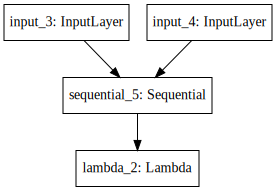

In [72]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

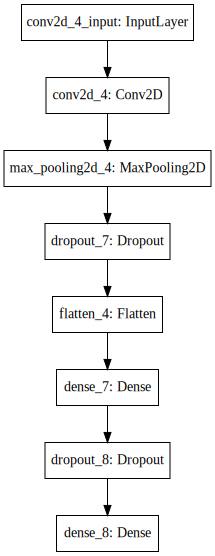

In [73]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(base_network).create(prog='dot', format='svg'))

In [119]:
nb_epoch=10

In [75]:
# train 10 epochs
rms = RMSprop()
model.compile(loss= contrastive_loss, optimizer=rms)
history = model.fit([tr_pairs1[:,0], tr_pairs1[:, 1]], tr_y,
          validation_data=([te_pairs1[:,0], te_pairs1[:, 1]], te_y),
          batch_size=128,
          nb_epoch=nb_epoch)



/home/aniruddha/anaconda3/envs/tensorflow/lib/python3.5/site-packages/ipykernel_launcher.py:7: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  import sys


Train on 108700 samples, validate on 17820 samples
Epoch 1/10
108700/108700 [==============================] - 84s 772us/step - loss: 0.4482 - val_loss: 0.5077
Epoch 2/10
108700/108700 [==============================] - 81s 749us/step - loss: 0.4337 - val_loss: 0.4793
Epoch 3/10
108700/108700 [==============================] - 81s 745us/step - loss: 0.4314 - val_loss: 0.4750
Epoch 4/10
108700/108700 [==============================] - 81s 744us/step - loss: 0.4301 - val_loss: 0.4604
Epoch 5/10
108700/108700 [==============================] - 83s 765us/step - loss: 0.4293 - val_loss: 0.4656
Epoch 6/10
108700/108700 [==============================] - 74s 682us/step - loss: 0.4288 - val_loss: 0.4661
Epoch 7/10
108700/108700 [==============================] - 74s 683us/step - loss: 0.4283 - val_loss: 0.4629
Epoch 8/10
108700/108700 [==============================] - 74s 682us/step - loss: 0.4281 - val_loss: 0.4598
Epoch 9/10
108700/108700 [==============================] - 74s 683us/step - 

In [101]:
# compute final accuracy on training and test sets
pred = model.predict([tr_pairs1[:,0], tr_pairs1[:, 1]])
tr_acc = compute_accuracy(pred, tr_y)
pred = model.predict([te_pairs1[:,0], te_pairs1[:, 1]])
te_acc = compute_accuracy(pred, te_y)

print('* Accuracy on training set: %0.2f%%' % (100 * tr_acc))
print('* Accuracy on test set: %0.2f%%' % (100 * te_acc))

* Accuracy on training set: 100.00%
* Accuracy on test set: 100.00%


In [122]:
y_test1=[]
for i in range(0,10):
    for j in range(1,201):
        y_test1.append(i)
y_test1=np.array(y_test1)
print(y_test1.size)
print(y_test1)

2000
[0 0 0 ... 9 9 9]


In [123]:
X_test1=[]
for i in range(0,10):
    for j in range(1,201):
        img = PIL.Image.open("/home/aniruddha/Documents/USPSdataset/%d/%d.jpg" %(i,j)).convert("L")
        arr = np.array(img)
        # ravel to convert 28x28 to 784 1D array
        arr=arr.ravel()
        X_test1.append(arr)
X_test1=np.array(X_test1)
print(X_test1.shape)
print(X_test.shape)

(2000, 784)
(10000, 784)


In [124]:
X_test1 = X_test1.reshape(2000, 784)
X_test1 = X_test1.astype('float32')
X_test1 /= 255
print(X_test.shape)


digit_indices = [np.where(y_test1 == i)[0] for i in range(10)]
te_pairs, te_y = create_pairs(X_test1, digit_indices)

(10000, 784)


In [125]:
te_pairs2=te_pairs.reshape(-1,2,28,28,1)

print(te_pairs2.shape)

(3980, 2, 28, 28, 1)


In [126]:
pred = model.predict([te_pairs2[:, 0], te_pairs2[:, 1]])
te_acc = compute_accuracy(pred, te_y)

# compute accuracy on new USPS dataset to check degree of transfer learning
# model only trained on MNIST dataset
print('* Accuracy on test set: %0.2f%%' % (100 * te_acc))

* Accuracy on test set: 93.94%


In [91]:
%matplotlib inline

from time import time

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import offsetbox
from sklearn import manifold, datasets, decomposition, ensemble, discriminant_analysis, random_projection

In [92]:
def plot_embedding(mu, Y, title=None):
    num_class = 1000 # data points per class
#     x_min, x_max = np.min(mu, 0), np.max(mu, 0)
#     mu = (mu - x_min) / (x_max - x_min)
    
#     classes = [0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 15, 16, 18, 19, 
#                20, 21, 22, 25, 26, 27, 28, 29, 30, 31, 32, 34, 35, 36, 37, 39, 40, 42, 43, 44, 45, 46, 48, 49]
    
    classes = [0,1,2,3,4,5,6,7,8,9]
    data = [[] for i in classes]
    for i, y in enumerate(Y):
        data[classes.index(y)].append(np.array(mu[i]))
            
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'olive', 'orange', 'mediumpurple']
    l = [i for i in range(10)]
    alphas = 0.3 * np.ones(10)

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_aspect(1)
    font_size = 13
    for i in range(10):
        temp = np.array(data[i])
        l[i] = plt.scatter(temp[:num_class, 0], temp[:num_class, 1], s = 5, c = colors[i], edgecolors = 'face', alpha=alphas[i])
    leg = plt.legend((l[0],l[1],l[2],l[3],l[4],l[5],l[6],l[7],l[8],l[9]), 
               ('0','1','2','3','4','5','6','7','8','9'), loc='center left', bbox_to_anchor=(1, 0.5), fontsize=font_size)
    leg.get_frame().set_linewidth(0.0)
    plt.xticks(fontsize=font_size)
    plt.yticks(fontsize=font_size)

In [127]:
X_test1=X_test1.reshape(-1,28,28,1)

In [128]:
test_model.compile(loss=contrastive_loss, optimizer=rms)
processed=test_model.predict(X_test1)

Computing t-SNE embedding


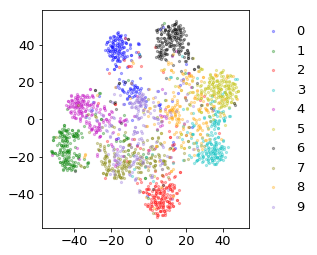

In [96]:
print("Computing t-SNE embedding")
tsne_pred = manifold.TSNE(n_components=2, init='pca', random_state=0)
t0 = time()
X_tsne_pred = tsne_pred.fit_transform(processed)

plot_embedding(X_tsne_pred, y_test1,
               "t-SNE embedding of the digits (time %.2fs)" %
               (time() - t0))

In [130]:
X_train11=X_train.reshape(-1,28,28,1)
X_test11=X_test.reshape(-1,28,28,1)

In [131]:
processed_train=test_model.predict(X_train11)
processed_test=test_model.predict(X_test11)

In [132]:
num_pixels = 128
processed_train = processed_train.reshape(processed_train.shape[0], num_pixels).astype('float32')
processed_test = processed_test.reshape(processed_test.shape[0], num_pixels).astype('float32')

print(num_pixels)
print(processed_train.shape)
print(processed_test.shape)

128
(60150, 128)
(10000, 128)


In [133]:
from keras.utils import np_utils
y_train1 = np_utils.to_categorical(y_train)
y_test1 = np_utils.to_categorical(y_test)
num_classes = 10

In [12]:
in_dim=128

In [39]:
import numpy

def create_kl_network(in_dim):
    """ Base network to be shared (eq. to feature extraction).
    """
    seq = Sequential()
    seq.add(Dense(128, input_shape=(in_dim,), activation='relu'))
    seq.add(Dropout(0.1))
    seq.add(Dense(128, activation='relu'))
    seq.add(Dropout(0.1))
    seq.add(Dense(128, activation='relu'))
    return seq

def create_kl_pairs_train(X_mnist, y_mnist, X_usps, Y_usps):
    "each pair contains one element from mnist and usps"
    pairs=[]
    labels=[]
    I=[]
    for i in range(0,150):
        for j in range(0,30000):
            pairs += [[X_mnist[j], X_usps[i]]]
            labels += [[y_mnist[j], y_usps[i]]]
            
            if(y_mnist[j]==y_usps[i]):
                I += [1]
            else:
                I += [0]
    return np.array(pairs), np.array(labels), np.array(I)

def combine(vects):
    x, y = vects
    return numpy.vstack((x,y))

def kl_divergence_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 10,2)
#def kl_divergence_loss()
    

In [22]:
X_mnist = processed_train[0:30000]
X_usps = processed_train[60000:60150]

y_mnist = y_train[0:30000]
y_usps = y_train[60000:60150]

NameError: name 'processed_train' is not defined

In [ ]:
tr_pairs, tr_labels, tr_I = create_pairs(X_mnist,y_mnist,X_usps,y_usps)

In [29]:
kl_network = create_kl_network(in_dim)

input_a = Input(shape=(in_dim,))
input_b = Input(shape=(in_dim,))

In [30]:
processed_kl_a = kl_network(input_a)
processed_kl_b = kl_network(input_b)

In [31]:
print(processed_kl_a.shape)

(?, 128)


In [32]:
softmax_kl_a = (Dense(10, activation = 'softmax'))(processed_kl_a)
softmax_kl_b = (Dense(10, activation = 'softmax'))(processed_kl_b)

In [33]:
print(softmax_kl_a.shape)

(?, 10)


In [40]:
output_vec = Lambda(combine, output_shape=kl_divergence_shape)([softmax_kl_a, softmax_kl_b])

AttributeError: 'numpy.ndarray' object has no attribute '_keras_shape'

In [ ]:
model_kl = Model(input=[input_a, input_b], output=output_vec)